# BASIC VAE  

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt

In [2]:
# Hyperparameters

input_dim = 784
hidden_dim = 256
latent_dim = 2
batch_size = 128
epochs = 10

In [3]:
# Encoder

class Encoder(Model):
    def __init__(self):
        super().__init__()
        self.dense = layers.Dense(hidden_dim, activation="relu")
        self.mu = layers.Dense(latent_dim)
        self.logvar = layers.Dense(latent_dim)

    def call(self, x):
        h = self.dense(x)
        return self.mu(h), self.logvar(h)

# Decoder

class Decoder(Model):
    def __init__(self):
        super().__init__()
        self.dense = layers.Dense(hidden_dim, activation="relu")
        self.out = layers.Dense(input_dim, activation="sigmoid")

    def call(self, z):
        h = self.dense(z)
        return self.out(h)

In [ ]:
# VAE

class VAE(Model):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def reparameterize(self, mu, logvar):
        eps = tf.random.normal(shape=tf.shape(mu))
        return mu + tf.exp(0.5 * logvar) * eps

    def train_step(self, x):
        with tf.GradientTape() as tape:
            mu, logvar = self.encoder(x)
            z = self.reparameterize(mu, logvar)
            x_hat = self.decoder(z)

            # Reconstruction loss (MANUAL BCE)
            recon_loss = -tf.reduce_sum(
                x * tf.math.log(x_hat + 1e-8) +
                (1 - x) * tf.math.log(1 - x_hat + 1e-8),
                axis=1
            )

            # KL 
            kl_loss = -0.5 * tf.reduce_sum(
                1 + logvar - tf.square(mu) - tf.exp(logvar),
                axis=1
            )

            loss = tf.reduce_mean(recon_loss + kl_loss)

        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {"loss": loss}

In [5]:
# Data 

(x_train, _), _ = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(-1, 784).astype("float32") / 255.0

In [6]:
# Train

vae = VAE()

vae.compile(optimizer=tf.keras.optimizers.Adam())
vae.fit(x_train, epochs=epochs, batch_size=batch_size)


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 201.9166
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 170.7945
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 166.4662
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 164.4626
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 163.0181
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 161.7254
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 160.6039
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 159.4996
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 158.4805
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 157.5342


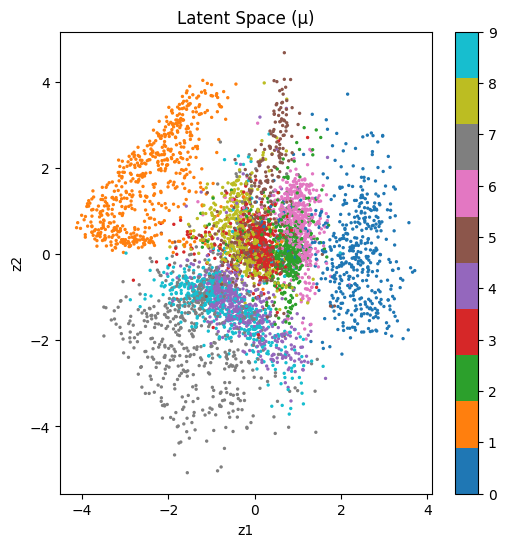

In [12]:
# Encode many images
mu, _ = vae.encoder(x_train[:5000])
mu = mu.numpy()

# Color by digit label
(_, y_train), _ = tf.keras.datasets.mnist.load_data()

plt.figure(figsize=(6, 6))
plt.scatter(mu[:, 0], mu[:, 1], c=y_train[:5000], cmap="tab10", s=2)
plt.colorbar()
plt.title("Latent Space (μ)")
plt.xlabel("z1")
plt.ylabel("z2")
plt.show()


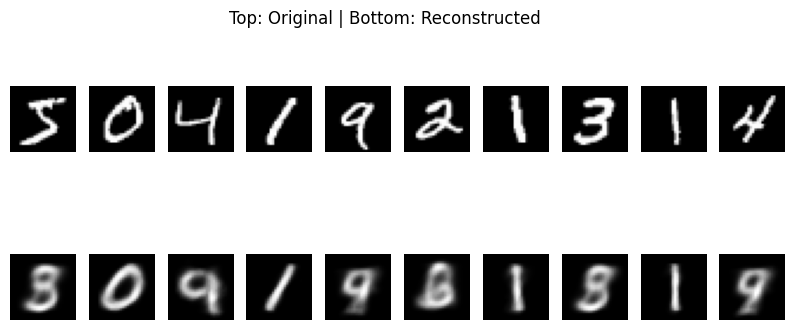

In [8]:

# Take some test images
x_test = x_train[:10]

# Encode → decode
mu, logvar = vae.encoder(x_test)
z = vae.reparameterize(mu, logvar)
x_recon = vae.decoder(z)

# Plot originals vs reconstructions
plt.figure(figsize=(10, 4))
for i in range(10):
    # Original
    plt.subplot(2, 10, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap="gray")
    plt.axis("off")

    # Reconstruction
    plt.subplot(2, 10, i + 11)
    plt.imshow(x_recon[i].numpy().reshape(28, 28), cmap="gray")
    plt.axis("off")

plt.suptitle("Top: Original | Bottom: Reconstructed")
plt.show()


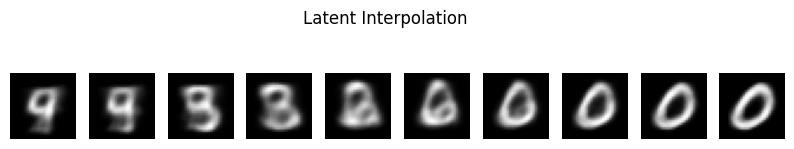

In [11]:
z1 = mu[4]
z2 = mu[1]

alphas = tf.linspace(0.0, 1.0, 10)
z_interp = tf.stack([(1 - a) * z1 + a * z2 for a in alphas])

x_interp = vae.decoder(z_interp)

plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(x_interp[i].numpy().reshape(28, 28), cmap="gray")
    plt.axis("off")

plt.suptitle("Latent Interpolation")
plt.show()
